<a href="https://colab.research.google.com/github/matidan01/DataIntensive/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Previsioni dei Podii Olimpici: Analisi delle Tendenze Storiche

Progetto di Programmazione di Applicazioni Data Intensive
a.a. 2023/2024

 **Realizzato da:**

 Mazzoni Gaia (gaia.mazzoni2@studio.unibo.it)

 D'Antino Matilde (matilde.dantino@studio.unibo.it)

Nel contesto delle competizioni olimpiche, prevedere i risultati e i medagliati è una sfida complessa, che richiede un'analisi approfondita dei dati storici. Il nostro progetto si propone di sviluppare un modello predittivo per anticipare i podi delle competizioni olimpiche, utilizzando un dataset completo che copre tutte le edizioni delle Olimpiadi dal 1896 al 2022.

# Caricamento Librerie
Le librerie necessarie per le operazioni sono le seguenti:


1.   Numpy
2.   pandas
...

Di seguito l'importazione di tali librerie.

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caricamento dei dati
Il dataset contenente tutte le informazioni necessarie proviene dal sito Kaggle, reperibile attraverso il link:
[dataset_olimpiadi_1896-2022](https://www.kaggle.com/datasets/piterfm/paris-2024-olympic-summer-games).

Questo dataset storico sui Giochi Olimpici include tutte le edizioni dalla prima Olimpiade di Atene nel 1896 fino a quella di Pechino nel 2022. Contiene risultati, medaglie, atleti e città ospitanti.
Il dataset comprende oltre 21.000 medaglie, 162.000 risultati, 74.000 atleti, 20.000 biografie e 53 città ospitanti dei Giochi Olimpici estivi e invernali.


## Significato delle colonne

Il dataset è costituito da 4 tabelle:
- olympic_athletes.csv
- olympic_hosts.csv
- olympic_medals.csv
- olympic_results.csv

Per il fine della nostra analisi è necessaria solo olympic_results.csv

Le feature presenti nel Dataset sono:

1. `discipline_title`: Il nome della disciplina sportiva
2.  `event_title`: Il titolo dell'evento specifico all'interno della disciplina
3. `slug_game`: L'identificatore unico della specifica edizione dei Giochi Olimpici. Ad esempio, "beijing-2022"
4. `participant_type`: Il tipo di partecipante, che può essere individuale (Athlete) o di squadra (GameTeam)
5. `medal_type`: Il tipo di medaglia vinta (oro, argento, bronzo). Ad esempio, può essere vuoto se non è stata vinta alcuna medaglia.
6. `athletes`: L'elenco degli atleti che partecipano, insieme ai loro URL di profilo. Questo può essere vuoto se l'informazione è specificata nelle colonne athlete_url e athlete_full_name.
7. `rank_equal`:  Indica se più partecipanti hanno la stessa posizione in classifica. Ad esempio, "False" (significa che la posizione non è condivisa con altri).
8. `rank_position`: La posizione in classifica dell'atleta o della squadra.
9. `country_name`: Il nome del paese dell'atleta o della squadra.
10. `country_code`: Il codice a due lettere del paese.
11. `country_3_letter_code`: Il codice a tre lettere del paese.
12. `athlete_url`:  URL del profilo dell'atleta.
13. `athlete_full_name`: Il nome completo dell'atleta.
14. `value_unit`: L'unità di misura del risultato. Ad esempio, "POINTS".
15. `value_type`:  Il tipo di risultato o misura.

La variabile che teneteremo di predire è:
- `medal_type`: Il tipo di medaglia vinta (oro, argento, bronzo).

In [77]:
#athletes = pd.read_csv("olympic_athletes.csv")
#hosts = pd.read_csv("olympic_hosts.csv")
#medals = pd.read_csv("olympic_medals.csv")

file_path = "olympic_results.csv"

results = pd.read_csv(file_path, index_col=0)
results.info(verbose = False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 162804 entries, Curling to Gymnastics Artistic
Columns: 14 entries, event_title to value_type
dtypes: object(14)
memory usage: 137.7 MB


In [78]:
results.head(1)

,event_title,slug_game,participant_type,medal_type,athletes,rank_equal,rank_position,country_name,country_code,country_3_letter_code,athlete_url,athlete_full_name,value_unit,value_type
discipline_title,,,,,,,,,,,,,,
Curling,Mixed Doubles,beijing-2022,GameTeam,GOLD,"[('Stefania CONSTANTINI', 'https://olympics.co...",False,1,Italy,IT,ITA,NaN,NaN,NaN,NaN


Osserviamo che sono presenti 14 features e tutte di tipo 'object', occupando 187.7MB.
Decidiamo quindi di ricaricare il dataset gestendo i dati meno complessi come categorici ("discipline_title", "event_title", "slug_game", "participant_type", "medal_type", "country_name", "country_code", "country_3_letter_code"), boolean ("rank_equal") o float ("rank_position"). Inoltre per quanto riguarda la colonna "rank_position" per comodità vengono convertiti i valori non numerici come "DNS" in valori di tipo NaN.

In [79]:
categorical = ["discipline_title", "event_title", "slug_game", "participant_type", "medal_type",
               "country_name", "country_code", "country_3_letter_code"]

results = pd.read_csv(file_path, index_col=0, dtype={x:"category" for x in categorical})
results['rank_equal'] = results['rank_equal'].astype('bool')
results['rank_position'] = pd.to_numeric(results['rank_position'], errors='coerce')

results.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 162804 entries, Curling to Gymnastics Artistic
Columns: 14 entries, event_title to value_type
dtypes: bool(1), category(7), float64(1), object(5)
memory usage: 49.1 MB


Notiamo come il dataset così caricato sia di 49.1MB ovvero il 30% di prima della conversione dei dati.

Notiamo, inoltre, che alcune features sono ripetute (ad esempio: country_name, country_code e country_3_letter_code). Possiamo quindi eliminare le colonne per risparmiare spazio.

In [80]:
import ast
import re

def extract_year(slug_game):
    return slug_game.split('-')[-1]

def remove_urls(athletes_str):
    if pd.isna(athletes_str):
        return athletes_str
    athletes_list = ast.literal_eval(athletes_str)
    names_only = [name for name, url in athletes_list]
    return ', '.join(names_only)

results['athletes'] = results['athletes'].apply(remove_urls)

results['slug_game'] = results['slug_game'].apply(extract_year)

results['athletes'] = results['athletes'].fillna(results['athlete_full_name'])

results.drop(columns=["country_code", "country_3_letter_code", "athlete_url", "medal_type", "athlete_full_name"], inplace=True);
results.head(100)


,event_title,slug_game,participant_type,athletes,rank_equal,rank_position,country_name,value_unit,value_type
discipline_title,,,,,,,,,
Curling,Mixed Doubles,2022,GameTeam,"Stefania CONSTANTINI, Amos MOSANER",False,1.0,Italy,NaN,NaN
Curling,Mixed Doubles,2022,GameTeam,"Kristin SKASLIEN, Magnus NEDREGOTTEN",False,2.0,Norway,NaN,NaN
Curling,Mixed Doubles,2022,GameTeam,"Almida DE VAL, Oskar ERIKSSON",False,3.0,Sweden,NaN,NaN
Curling,Mixed Doubles,2022,GameTeam,"Jennifer DODDS, Bruce MOUAT",False,4.0,Great Britain,NaN,NaN
Curling,Mixed Doubles,2022,GameTeam,"Rachel HOMAN, John MORRIS",False,5.0,Canada,NaN,NaN
...,...,...,...,...,...,...,...,...,...
Freestyle Skiing,Men's Freeski Big Air,2022,Athlete,Kim GUBSER,False,23.0,Switzerland,79.75,POINTS
Freestyle Skiing,Men's Freeski Big Air,2022,Athlete,Max MOFFATT,False,20.0,Canada,61.00,POINTS
Freestyle Skiing,Men's Freeski Big Air,2022,Athlete,Javier LLISO,False,6.0,Spain,79.50,POINTS


In [81]:
results.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 162804 entries, Curling to Gymnastics Artistic
Columns: 9 entries, event_title to value_type
dtypes: bool(1), category(3), float64(1), object(4)
memory usage: 37.8 MB


# Analisi generale dei dati

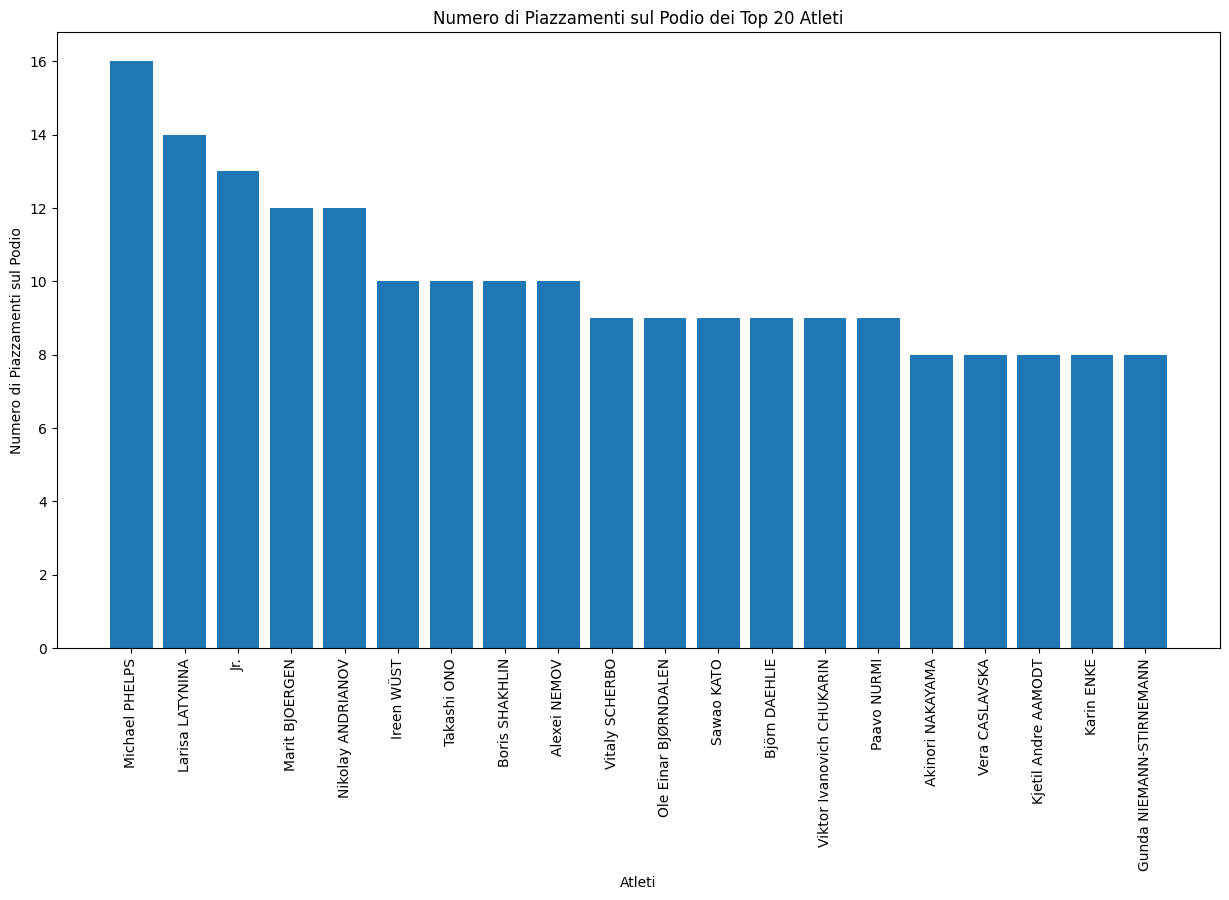

In [82]:
#voglio trovare gli atleti con il maggior numero di vittorie

#questo metodo mi restituisce un dizionario (nome, vittorie per eventi)
def get_all_athletes_and_podiums(athletes_results):
  all_athletes = {}
  for athlete in athletes_results['athletes']:
    if not pd.isna(athlete):
      athlete_list = athlete.split(", ")
      for a in athlete_list:
        if a in all_athletes:
          all_athletes[a] += 1
        else:
          all_athletes[a] = 1
  return all_athletes


filtered_results = results[results['rank_position'] <= 3.0]
athletes_and_podiums = get_all_athletes_and_podiums(filtered_results)

data = {
    'Athlete' : athletes_and_podiums.keys(),
    'TimesOnPodium' : athletes_and_podiums.values()
}

df_athletes_and_podiums = pd.DataFrame(data)
top_20_participants = df_athletes_and_podiums.sort_values(by='TimesOnPodium', ascending=False).head(20)


plt.figure(figsize=(15, 8))
bars = plt.bar(top_20_participants['Athlete'], top_20_participants['TimesOnPodium'])

for bar in bars:
    yval = bar.get_height()

plt.xticks(rotation=90)
plt.xlabel('Atleti')
plt.ylabel('Numero di Piazzamenti sul Podio')
plt.title('Numero di Piazzamenti sul Podio dei Top 20 Atleti')
plt.show()


<ipython-input-83-9425216cd851>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  athletes_per_country = exploded_df.groupby('country_name')['athletes'].count().reset_index()


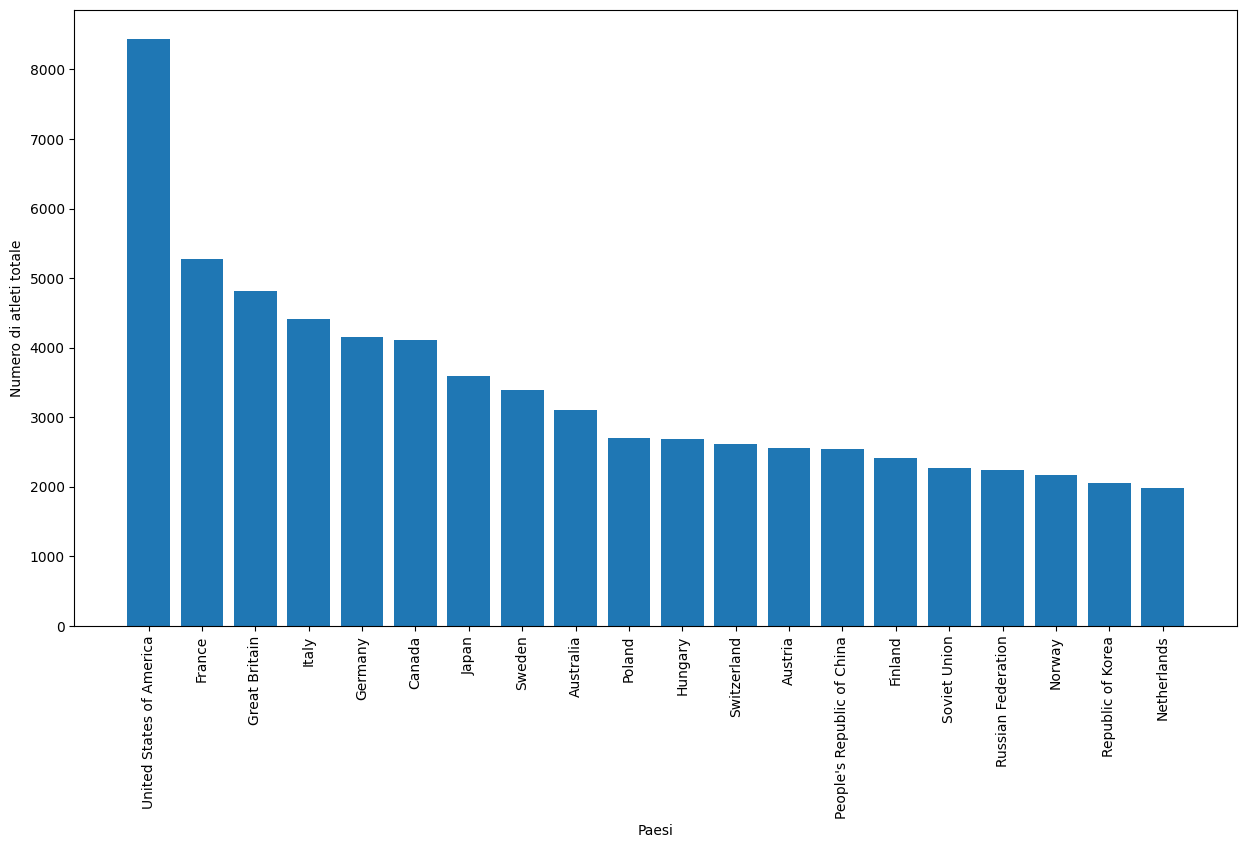

In [83]:
#plot bar numero atleti

exploded_df = results.assign(athlete=results['athletes'].str.split(', ')).explode('athlete')
exploded_df = exploded_df.drop_duplicates(subset=['athlete', 'slug_game'])
athletes_per_country = exploded_df.groupby('country_name')['athletes'].count().reset_index()
athletes_per_country.columns = ['CountryName', 'NumberOfAthletes']

highest_sending_countries = athletes_per_country.sort_values(by='NumberOfAthletes', ascending=False).head(20)

plt.figure(figsize=(15, 8))
bars = plt.bar(highest_sending_countries['CountryName'], highest_sending_countries['NumberOfAthletes'])

for bar in bars:
    yval = bar.get_height()

plt.xticks(rotation=90)
plt.xlabel('Paesi')
plt.ylabel('Numero di atleti totale')
plt.show()

In [141]:
#rimuovere valori fuori norma

to_drop = results.copy()
#to_drop[to_drop['athletes'].astype(str).str.contains("jr", case=False, na=False)]
#with pd.option_context('display.max_rows', None):
    #print(to_drop['country_name'].drop_duplicates())
to_drop[to_drop['athletes'].astype(str).str.contains("nan", case=False)]

,discipline_title,event_title,slug_game,participant_type,athletes,rank_equal,rank_position,country_name,value_unit,value_type
10,Curling,Women,2022,GameTeam,[nan],False,1.0,Great Britain,NaN,NaN
11,Curling,Women,2022,GameTeam,[nan],False,2.0,Japan,NaN,NaN
12,Curling,Women,2022,GameTeam,[nan],False,3.0,Sweden,NaN,NaN
13,Curling,Women,2022,GameTeam,[nan],False,4.0,Switzerland,NaN,NaN
14,Curling,Women,2022,GameTeam,[nan],False,5.0,Canada,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
162336,Gymnastics Artistic,team parallel bars men,1896,GameTeam,[nan],True,2.0,Greece,NaN,POINTS
162338,Gymnastics Artistic,team horizontal bar men,1896,GameTeam,[nan],True,1.0,Germany,NaN,POINTS
162636,Alpine Skiing,slalom men,1980,Athlete,[Francisco FERNANDEZ OCHOA],True,22.0,Spain,111610,TIME
162718,Equestrian Jumping,Jumping Individual mixed,1976,Athlete,[Fernando SENDEROS],True,21.0,Mexico,NaN,NaN


In [85]:
# Numero medio di partecipanti per paese ad olimpiade

res = results
res.reset_index(inplace=True)

res['athletes'] = res['athletes'].astype(str)
res['athletes'] = res['athletes'].apply(lambda x: x.split(', '))
res = res.explode('athletes')

athlete_counts = res.groupby(['slug_game', 'country_name'], observed=False).size().reset_index(name='athlete_count')
average_counts = athlete_counts.groupby('country_name', observed=False)['athlete_count'].mean().reset_index(name='average_athletes')

print(average_counts.sort_values("average_athletes").tail(10))

print("\n\n")

# Numero medio di partecipanti per sport ad olimpiade
participant_counts = res.groupby(['discipline_title', 'event_title', 'slug_game'], observed=False).size().reset_index(name='participant_count')
average_participants = participant_counts.groupby(['discipline_title', 'event_title'], observed=False).agg({
    'participant_count': 'mean'
}).reset_index()

print(average_participants.sort_values("participant_count").tail(10))

                 country_name  average_athletes
190               Switzerland        110.324324
10                  Australia        118.675676
189                    Sweden        144.648649
98                      Japan        146.216216
34                     Canada        166.108108
73                    Germany        167.945946
95                      Italy        179.405405
75              Great Britain        185.297297
69                     France        215.837838
207  United States of America        337.486486



           discipline_title                   event_title  participant_count
44792    Equestrian Jumping              individual mixed          28.702703
78506              Shooting  50m rifle prone 60 shots men          29.486486
86812           Ski Jumping    Normal Hill Individual men          31.081081
25219  Cross Country Skiing                      50km men          32.297297
2448          Alpine Skiing                  downhill men          32.351351
2526   